# Aggregating data from an annotation corpus

This notebook shows how to:
1. Create a sample of annotations from a corpus using the ParameterSearch class
2. Create a parameter sample using NAT-ANALYTICS ParamSample class
3. Preprocess the sample to keep only relevant records
4. Display some graphs using NAT-ANALYTICS ploting functions
5. Aggregate valid data (using NAT-ANALYTICS SampleAggregator) so that average values are ready for incorporation into models
6. Show the JSON representation of the parameter aggregation
7. Save the resulting aggregation object
8. Show what values have been rejected and why

### Updating literature annotation corpus

In [1]:
from git import Repo
import os
import numpy as np


git_url = "https://github.com/christian-oreilly/corpus-thalamus.git"
repo_dir = os.path.join(os.getcwd(), "neurocuratorDB")
if not os.path.isdir(repo_dir):
    Repo.clone_from(git_url, repo_dir)
else:
    Repo(repo_dir).remotes.origin.pull()

### Getting neuron densities from curated literature

In [2]:
from nat.annotationSearch import ParameterSearch, ConditionAtom
from natanalytics.ageResolver import AgeResolver
from natanalytics.paramSample import ParamSample
searcher = ParameterSearch(pathDB="neurocuratorDB")
searcher.setSearchConditions(ConditionAtom("Parameter name", "neuron_density"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True

sample = ParamSample(searcher, 
                     "427244", 
                     "group", 
                     "4D3rDZsAVBd139alqoVZBKOO")

Loading cached Zotero data...
Cached Zotero data loaded.


In [3]:
sample.sampleDF.head()[["AgeCategories", "Cell", "Context", "Regional part of brain",
                       "Species", "Text", "Unit", "Values"]]

,AgeCategories,Cell,Context,Regional part of brain,Species,Text,Unit,Values
0,[],Thalamic reticular nucleus cell,,Thalamic reticular nucleus - medial tier,"[{'id': 'NIFORG:nlx_organ_20081201', 'name': '...",Table 1,1/mm^3,18120
1,[],Thalamus interneuron small,,Lateral geniculate body,"[{'id': 'NIFORG:birnlex_254', 'name': 'Wistar ...",Table 1,mm^-2,48.4
2,[],Neuron,,Ventral posterior nucleus,"[{'id': 'NIFORG:birnlex_266', 'name': 'Sprague...",Figure 3.C,1/mm^3,55634.3
3,[],Neuron,lm thick sections from 14to 21-day-old rats). ...,Lateral geniculate body,"[{'id': 'NIFORG:nlx_organ_20081201', 'name': '...","overall density of neurons in the dLGN\nof 5,4...",1/mm^2,5434
4,[],Neuron,,Ventral posterolateral nucleus,"[{'id': 'NCBITaxon:9986', 'name': 'Oryctolagus...",Table 2,mm^-3,"[162849.0, 93747.0, 45284.0, 27371.0, 20448.0,..."


### Preprocessing the data to homogenize them

In [4]:
# Get the species, the age, and the reference for the fetched annotations
sample.preprocess(["species", "age", "ref"]) # 

# Rescale brain region volumes to a common unit
sample.rescaleUnit("1/mm^3", rescaleStereo=False)

# Presently not working because of changes in NIF infrastructure. 
# See https://github.com/BlueBrain/nat/issues/16
#sample.filter_species("NIFORG:birnlex_160") # Rat

# Set records with an undefined status (i.e., record that have not been
# explicitly set as invalid) as valid.
sample.validateUndefined()

sample.sampleDF[["Regional part of brain", "Values", "Unit", 
                 "Species", "AgeCategory", "age", "ref", "isValid"]].head()

,Regional part of brain,Values,Unit,Species,AgeCategory,age,ref,isValid
0,Thalamic reticular nucleus - medial tier,18120,1/mm^3,Long Evans Rat,None,None,Ross et al. (1995),True
1,Lateral geniculate body,48.4,mm^-2,Wistar Rat,None,273.93164908593747 d,Cavdar et al. (2014),False
2,Ventral posterior nucleus,55634.3,1/mm^3,Sprague Dawley,None,None,Lifshitz et al. (2007),True
3,Lateral geniculate body,5434,1/mm^2,Long Evans Rat,None,17.5 d,Meuth et al. (2005),False
4,Ventral posterolateral nucleus,[162849. 93747. 45284. 27371. 20448. 2114...,1/mm**3,Oryctolagus cuniculus,None,None,Luczyńska et al. (2003),True


### Displaying neuron densities as function of the age, using different lines for different brain regions

Loading cached Zotero data...
Cached Zotero data loaded.


/home/oreilly/python_venv/venv-3.4/lib/python3.5/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


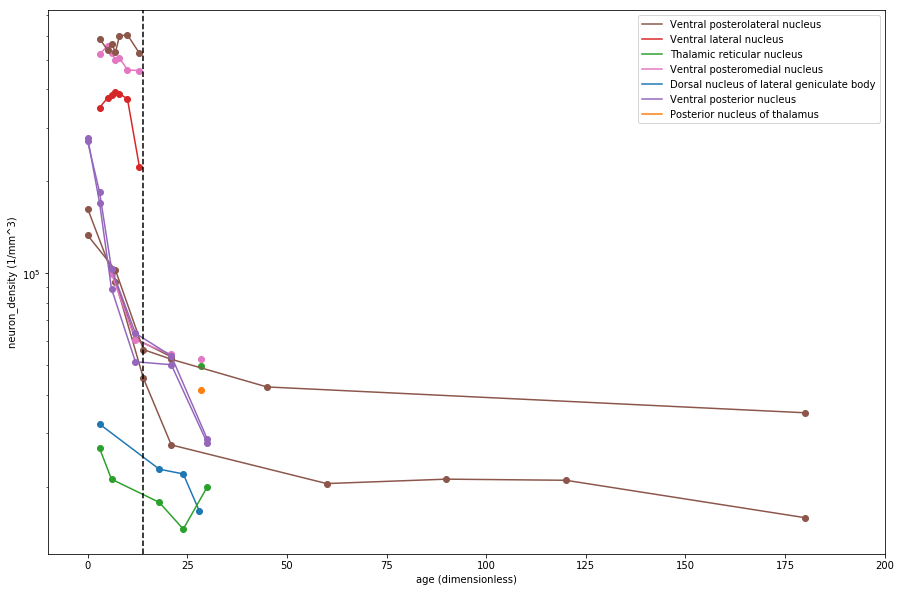

In [5]:
%matplotlib inline
from natanalytics.plot import plotTraces
ageExp = 14

fig, ax = plotTraces(sample, x="age", labels="Regional part of brain", 
                     figsize=(15, 10))
ax.set_yscale('log')
ax.set_xlim([-10, 200])
ylim = ax.get_ylim()
ax.set_ylim(ylim)
ax.plot([ageExp, ageExp], ylim, "k--")

### Displaying neuron densities as function of the age, using separate panels for the different brain regions and different lines for the different papers.

Loading cached Zotero data...
Cached Zotero data loaded.


/home/oreilly/python_venv/venv-3.4/lib/python3.5/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/home/oreilly/python_venv/venv-3.4/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=28.5, right=28.5
  'left=%s, right=%s') % (left, right))


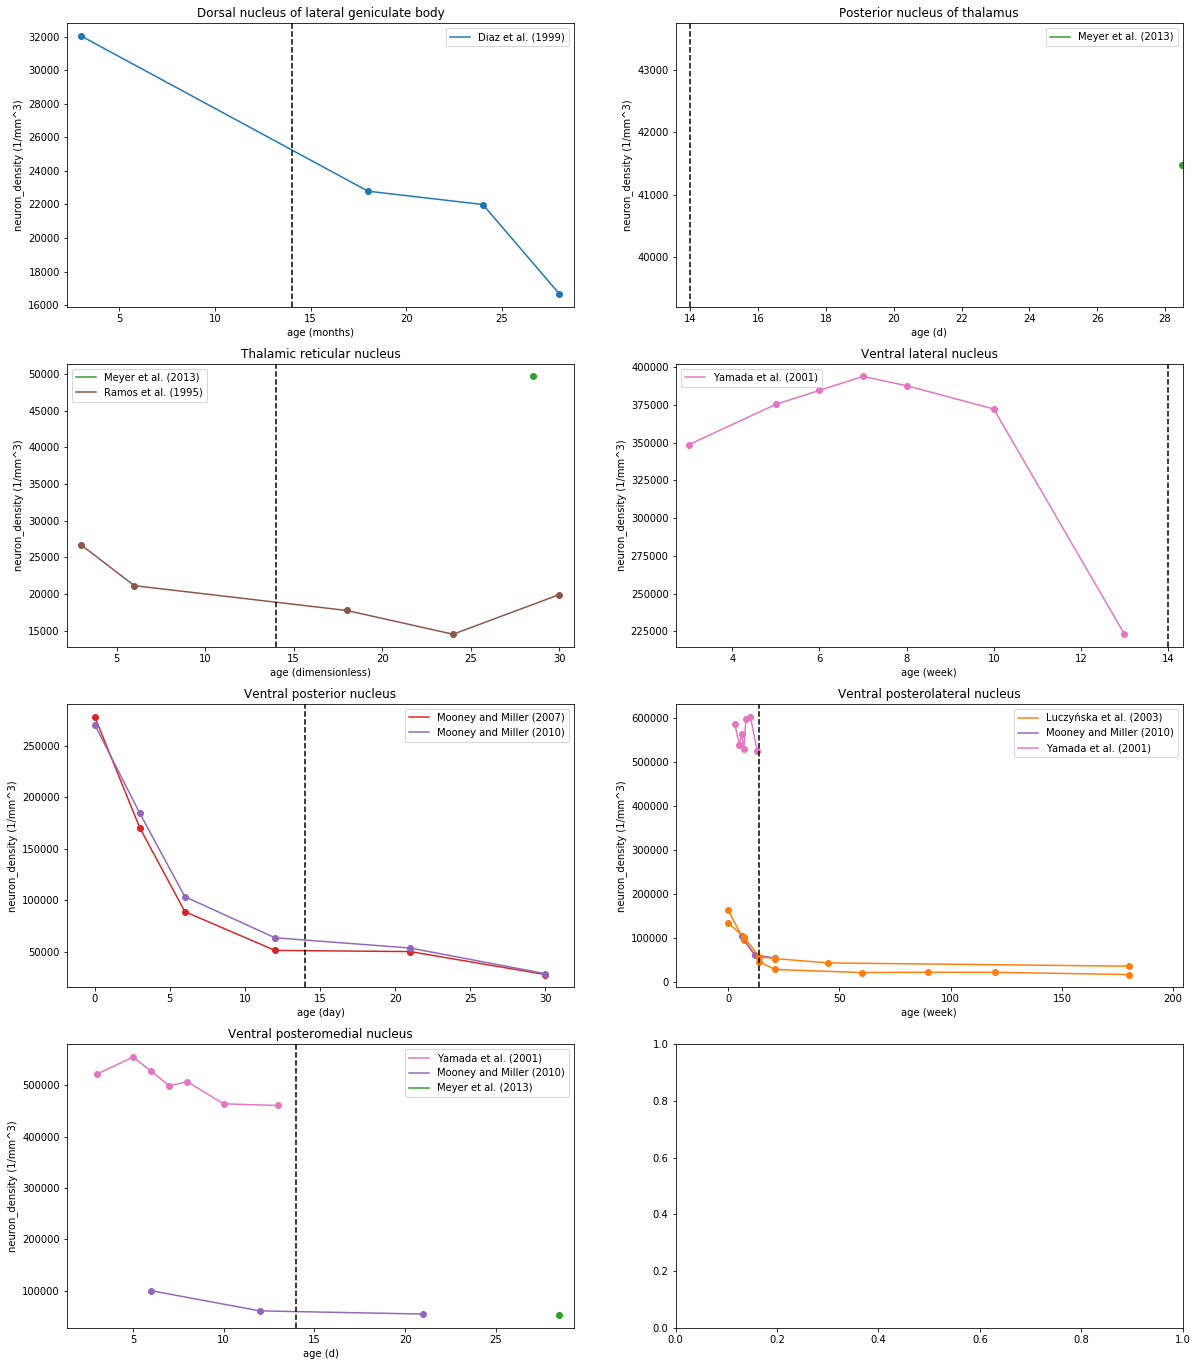

In [6]:
%matplotlib inline
from natanalytics.plot import plotTraces
from collections.abc import Iterable   # import directly from collections for Python < 3.3

nbCols = 2
ageExp = 14


fig, axarr = plotTraces(sample, x="age", panels="Regional part of brain", 
                        labels="ref", nbCols=nbCols)

if not isinstance(axarr, Iterable):
    axarr = np.array([axarr])
unique_regions = [ax.title.get_text() for ax in list(axarr.flat) if ax.title.get_text()]
for no, brainRegion in enumerate(unique_regions):
    axes = axarr[int(no/nbCols), np.mod(no, nbCols)]    
    
    ylim = list(axes.get_ylim())
    xlim = list(axes.get_xlim())
    if ageExp >= xlim[1]:
        xlim[1] = (ageExp- xlim[0])*0.03 + ageExp
    if ageExp <= xlim[0]:
        xlim[0] = - (xlim[1] - ageExp)*0.03 + ageExp

    axes.plot([ageExp, ageExp], ylim, "k--")
    axes.set_ylim(ylim)
    axes.set_xlim(xlim)

### Interpolating at P14

In [7]:
sample.interpolate({"age": 14})

### Printing a sumary of the operation that has been performed on the sample

In [8]:
print(sample.report)

Search : Using central tendencies for single annotations containing multiple values.
Extracting species from annotations.
Preprocessing age information.
Preprocessing associated references.
Rescaling the units to '1/mm^3'.
Validated parameters with undefined status.
Interpolation of the parameters for independent variables 'age' at value 14.



### Listing the final sample of valid records

In [9]:
sample.validSample[["Regional part of brain", "Values", "Unit", 
                    "Species", "age", "ref", "Cell", "Result type"]]

,Regional part of brain,Values,Unit,Species,age,ref,Cell,Result type
0,Thalamic reticular nucleus - medial tier,18120,1/mm^3,Long Evans Rat,None,Ross et al. (1995),Thalamic reticular nucleus cell,pointValue
2,Ventral posterior nucleus,55634.3,1/mm^3,Sprague Dawley,None,Lifshitz et al. (2007),Neuron,pointValue
4,Ventral posterolateral nucleus,45284,1/mm**3,Oryctolagus cuniculus,None,Luczyńska et al. (2003),Neuron,numericalTrace
6,Ventral lateral nucleus,348586,1/mm^3,C57BL,None,Yamada et al. (2001),Neuron,numericalTrace
7,Ventral posterolateral nucleus,59248.3,1/mm^3,Long Evans Rat,None,Mooney and Miller (2010),Thalamus relay cell,numericalTrace
8,Thalamic reticular nucleus,17800,1/mm^3,Long Evans Rat,None,Ross et al. (1995),Thalamic reticular nucleus cell,pointValue
9,Thalamic reticular nucleus,49680,1/mm^3,Wistar Rat,28.5 d,Meyer et al. (2013),Neuron,pointValue
11,Thalamic reticular nucleus,3781.52,1/mm^3,Sprague Dawley,None,Huusko and Pitkänen (2014),Thalamic reticular nucleus cell - PV+,pointValue
12,Ventral posteromedial nucleus,521600,1/mm^3,C57BL,None,Yamada et al. (2001),Neuron,numericalTrace
15,Ventral posteromedial nucleus,58972,1/mm^3,Long Evans Rat,None,Mooney and Miller (2010),Thalamus relay cell,numericalTrace


### Aggregating the data so that we can reduce samples of data points into single values to be used in models

In [10]:
from natanalytics.aggregators import SampleAggregator

categoryGrouping = [
                     [('Thalamus relay cell', 'Posterior nucleus of thalamus'),
                      ('Neuron', 'Posterior nucleus of thalamus')],
                     [('Thalamus relay cell', 'Ventral posterior nucleus'),
                      ('Neuron', 'Ventral posterior nucleus')],
                     [('Thalamus relay cell', 'Ventral posterolateral nucleus'),
                      ('Neuron', 'Ventral posterolateral nucleus')],
                     [('Thalamus relay cell', 'Ventral posteromedial nucleus'),
                      ('Neuron', 'Ventral posteromedial nucleus')],
                     [('Thalamic reticular nucleus cell',
                       'Thalamic reticular nucleus'),
                      ('Neuron', 'Thalamic reticular nucleus'),
                      ('Thalamic reticular nucleus cell',
                       'Thalamic reticular nucleus - central tier'),
                      ('Thalamic reticular nucleus cell',
                       'Thalamic reticular nucleus - lateral tier'),
                      ('Thalamic reticular nucleus cell',
                       'Thalamic reticular nucleus - medial tier'),
                      ('Thalamic reticular nucleus cell - PV+',
                       'Thalamic reticular nucleus')]
                   ]

aggregator = SampleAggregator(paramName="neuron_density",
                              groupingFactors=["Cell", "Regional part of brain"],
                              method="mean", 
                              categoryGrouping=categoryGrouping)

sample.addAggregator(aggregator)

### Displaying computed aggregated values

In [11]:
densities = aggregator.values(sample)
densities

{('Neuron', 'Dorsal nucleus of lateral geniculate body'): 32660.566666666666,
 ('Neuron', 'Parafascicular nucleus'): 51465.0,
 ('Neuron', 'Ventral lateral nucleus'): 348586.0,
 ('Thalamic reticular nucleus cell',
  'Thalamic reticular nucleus'): 21877.12203283862,
 ('Thalamus relay cell', 'Posterior nucleus of thalamus'): 41477.0,
 ('Thalamus relay cell', 'Ventral posterior nucleus'): 55993.00244000556,
 ('Thalamus relay cell', 'Ventral posterolateral nucleus'): 186981.57952177996,
 ('Thalamus relay cell', 'Ventral posteromedial nucleus'): 211022.0084545886}

### The aggregation object has all the information necessary to reproduce these operations at a later time. For convenience, this information is encoded in a JSON structure. Such structure can be registered in NEXUS for provenance tracking.

In [12]:
json = sample.toJSON()
json

{'ageTypeValue': 'min',
 'ageUnit': 'day',
 'aggregators': {'neuron_density': {'aggreatedLst': [{'ids': ('efe17746-f460-11e7-b8d3-acbc328c3997',
      '48af896a-8280-11e7-9105-64006a67e5d0'),
     'index': ('Neuron', 'Dorsal nucleus of lateral geniculate body'),
     'value': 32660.566666666666},
    {'ids': ('25f3f82a-8280-11e7-9105-64006a67e5d0',),
     'index': ('Neuron', 'Parafascicular nucleus'),
     'value': 51465.0},
    {'ids': ('5b114858-31a0-11e8-b594-64006a67e5d0',),
     'index': ('Neuron', 'Ventral lateral nucleus'),
     'value': 348586.0},
    {'ids': ('6ac22732-8024-11e7-9d91-64006a67e5d0',
      'cb53ae1a-8022-11e7-9d91-64006a67e5d0',
      '4ab62f4e-8036-11e7-9d91-64006a67e5d0',
      'ac71e7f8-802e-11e7-9d91-64006a67e5d0',
      'ebff776e-8024-11e7-9d91-64006a67e5d0',
      'bbb668d0-7e97-11e7-8d14-64006a67e5d0',
      '2a18044a-8281-11e7-9105-64006a67e5d0',
      '2f01821c-8027-11e7-9d91-64006a67e5d0'),
     'index': ('Thalamic reticular nucleus cell',
      'Thala

### Saving the aggregation object for later reuse

In [13]:
sample.save("density_aggregation.json")

### We can have a look at what records have been dropped from the sample. The statusStr columns shows a short description of why each of these records has been dropped.

In [14]:
sample.invalidSample[["Regional part of brain", "Values", "Unit", 
                      "Species", "age", "ref", "Cell", "statusStr"]] #

,Regional part of brain,Values,Unit,Species,age,ref,Cell,statusStr
1,Lateral geniculate body,48.4,mm^-2,Wistar Rat,273.93164908593747 d,Cavdar et al. (2014),Thalamus interneuron small,Cannot be rescaled to unit 1/mm^3\n
3,Lateral geniculate body,5434,1/mm^2,Long Evans Rat,17.5 d,Meuth et al. (2005),Neuron,Cannot be rescaled to unit 1/mm^3\n
5,Lateral geniculate body,246.8,mm^-2,Wistar Rat,273.93164908593747 d,Cavdar et al. (2014),Thalamus relay cell,Cannot be rescaled to unit 1/mm^3\n
10,thalamic reticular nucleus,700,1/mm^2,Rat,None,Arcelli et al. (1997),Thalamic reticular nucleus cell,Cannot be rescaled to unit 1/mm^3\n
13,Ventral posterolateral nucleus,5.9,mm^-2,Wistar Rat,273.93164908593747 d,Cavdar et al. (2014),Thalamus interneuron small,Cannot be rescaled to unit 1/mm^3\n
14,Thalamic reticular nucleus,29.82,mm^-2,Wistar Rat,None,Cavdar et al. (2013),Thalamic reticular nucleus cell - non-GABAergic,Cannot be rescaled to unit 1/mm^3\n
19,Ventral posteromedial nucleus,13.3,mm^-2,Wistar Rat,273.93164908593747 d,Cavdar et al. (2014),Thalamus interneuron small,Cannot be rescaled to unit 1/mm^3\n
24,Ventral posterolateral nucleus,150.3,mm^-2,Wistar Rat,273.93164908593747 d,Cavdar et al. (2014),Thalamus relay cell,Cannot be rescaled to unit 1/mm^3\n
27,Thalamic reticular nucleus,"[848.5716716939, 792.1346189579, 786.375710718...",1/mm^2,Sprague Dawley,None,Huusko and Pitkänen (2014),Thalamic reticular nucleus cell - PV+,Cannot be rescaled to unit 1/mm^3\n
28,Thalamic reticular nucleus,"[867.5959705546, 796.7703072175, 794.839499220...",1/mm^2,Sprague Dawley,None,Huusko and Pitkänen (2014),Thalamic reticular nucleus cell - PV+,Cannot be rescaled to unit 1/mm^3\n
